In [138]:
import json
import jieba
import numpy as np
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from tqdm import tqdm
import os
import re


In [ ]:
# =================配置区域=================
DATA_PATH = '../dataset/train.jsonl'          # 语料库路径
GLOVE_PATH = '../wiki_giga_2024_200_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt'    # 英文预训练向量路径
FASTTEXT_PATH = '../cc.zh.300.bin'     # 中文预训练向量路径
OUTPUT_DIR = '../processed_data'     # 输出目录

# 特殊Token定义
pad_TOKEN = '<pad>'
unk_TOKEN = '<unk>'
sos_TOKEN = '<sos>'
eos_TOKEN = '<eos>'
SPECIAL_TOKENS = [pad_TOKEN, unk_TOKEN, sos_TOKEN, eos_TOKEN]

# 词表构建阈值 (可以根据生成的图表调整)
# 设定最小词频，低于此频率的词将被视为 <unk>
MIN_FREQ_EN = 0  
MIN_FREQ_ZH = 0
# 或者设定最大词表大小 (None表示不限制，完全由min_freq控制)
MAX_VOCAB_EN = 40000 
MAX_VOCAB_ZH = 40000


# 定义： 清理 分词 加载和处理语料库 统计词表覆盖率 选定词表大小 构建词库

In [ ]:
# =================1. 清理与Tokenize=================
def normalize_en_punctuation(text):
    """
    将英文文本中的全角（中文）标点、空格替换为半角（英文）标点。
    """
    # 定义映射表
    punctuation_map = {
        '，': ',',
        '。': '.', 
        '！': '!', 
        '？': '?', 
        '；': ';',
        '：': ':',
        '“': '"',
        '”': '"', 
        '‘': "'",
        '’': "'",
        '（': '(',
        '）': ')', 
        '【': '[',
        '】': ']',
        '-': '-',
        '～': '~',
        '．': '.',
        '　': ' ' # 包含全角空格
    }
    # 创建转换表
    table = str.maketrans(punctuation_map)
    return text.translate(table)
def tokenize_en(text):
    """
    英文处理：转小写 + NLTK分词。
    这与GloVe (uncased) 的训练预处理高度一致。
    """
    # 替换中文标点为英文标点
    text = normalize_en_punctuation(text)
    re.sub(r'[^\x00-\x7f]', r'', text)
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', ' ', text)  # 移除控制字符（必须）
    text = text.lower().strip()

    # 处理 Unicode 乱码和特殊符号
    text = text.replace('\xad', '').replace('', '')
    
    # 在货币符号和数字之间加入空格 (e.g., €50 -> € 50)
    text = re.sub(r'([€£¥$]|cn¥)([0-9])', r'\1 \2', text)
    text = text.replace('cn¥','¥')
    # 处理斜杠 (e.g., and/or -> and / or)
    # 注意：为了防止破坏 URL，我们只处理单词间的斜杠
    text = re.sub(r'([a-zA-Z])\/([a-zA-Z])', r'\1 / \2', text)
    
    # 分离末尾粘连的标点 (e.g., 2015. -> 2015 .)
    # NLTK 有时处理不好紧跟数字的句号
    text = re.sub(r'([0-9])(\.)(?=\s|$)', r'\1 \2', text)
    
    # 统一温度符号
    text = text.replace('°c', ' degree').replace('ºc', ' degree').replace('º', ' degree')

    text = re.sub(r'\s+', ' ', text).strip()
    return nltk.word_tokenize(text)

def tokenize_zh(text):
    """
    中文处理：Jieba分词
    """
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', ' ', text)  # 移除控制字符
    text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9\s.,!?;:\'"()\-\[\]/–—\u3000-\u303F\uFF01-\uFF5E]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    s = jieba.lcut(text)
    return [w for w in s if w != ' ']

def load_and_tokenize(file_path):
    print(f"正在读取并分词: {file_path} ...")
    en_tokens_all = []
    zh_tokens_all = []
    
    en_cleaned_toknized_texts=[]
    zh_cleaned_toknized_texts=[]
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    for line in tqdm(lines, desc="Processing lines"):
        try:
            data = json.loads(line)
            # 提取英文和中文(zh_hy)
            en_text = data.get('en', "")
            zh_text = data.get('zh_hy', "")
            
            if en_text and zh_text:
                ent=tokenize_en(en_text)
                zht=tokenize_zh(zh_text)
                en_tokens_all.extend(ent)
                zh_tokens_all.extend(zht)
                en_cleaned_toknized_texts.append(ent)
                zh_cleaned_toknized_texts.append(zht)
        except json.JSONDecodeError:
            print("json DecoderError")
            continue
            
    return en_tokens_all, zh_tokens_all , en_cleaned_toknized_texts ,zh_cleaned_toknized_texts

# =================2. 统计覆盖率与词表关系=================

def analyze_coverage(tokens, lang_name):
    """
    统计词频，计算词表大小与语料覆盖率(Coverage)的关系，并绘图。
    """
    print(f"\n正在分析 {lang_name} 语料覆盖率...")
    counter = Counter(tokens)
    total_tokens = len(tokens)
    unique_words = len(counter)
    
    # 按频率从高到低排序
    sorted_words = counter.most_common()
    
    x_vocab_size = []
    y_coverage = []
    
    current_count = 0
    # 为了绘图速度，每隔一定步长记录一次点
    step = max(1, unique_words // 200) 
    
    for i, (word, count) in enumerate(sorted_words):
        current_count += count
        if (i + 1) % step == 0 or (i + 1) == unique_words:
            x_vocab_size.append(i + 1)
            y_coverage.append(current_count / total_tokens * 100)
            
    # 绘图
    plt.figure(figsize=(10, 6))
    plt.plot(x_vocab_size, y_coverage, label=f'{lang_name} Coverage')
    plt.xlabel('Vocabulary Size (Number of Unique Words)')
    plt.ylabel('Token Coverage (%)')
    plt.title(f'{lang_name} Vocabulary Coverage Analysis')
    plt.grid(True)
    plt.axhline(y=95, color='r', linestyle='--', alpha=0.5, label='95% Coverage')
    plt.axhline(y=99, color='g', linestyle='--', alpha=0.5, label='99% Coverage')
    plt.axhline(y=99.5, color='b', linestyle='--', alpha=0.5, label='99.5% Coverage')
    plt.legend()
    
    # 找到几个关键点的词表大小
    cov_995 = next((x for x, y in zip(x_vocab_size, y_coverage) if y >= 99.5), unique_words)
    cov_95 = next((x for x, y in zip(x_vocab_size, y_coverage) if y >= 95), unique_words)
    cov_99 = next((x for x, y in zip(x_vocab_size, y_coverage) if y >= 99), unique_words)
    
    print(f"[{lang_name}] 总Token数: {total_tokens}, 唯一词数: {unique_words}")
    print(f"[{lang_name}] 95% 覆盖率所需词表大小: ~{cov_95}")
    print(f"[{lang_name}] 99% 覆盖率所需词表大小: ~{cov_99}")
    print(f"[{lang_name}] 99.5% 覆盖率所需词表大小: ~{cov_995}")
    
    # 保存图片
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
    plt.savefig(os.path.join(OUTPUT_DIR, f'{lang_name}_coverage.png'))
    print(f"[{lang_name}] 覆盖率分析图已保存。")
    
    return counter

# =================3. 构建词库 (Vocab) =================
def build_vocab(counter, min_freq, max_size):
    """
    根据阈值构建 word2idx 映射
    """
    # 过滤低频词
    words = [w for w, c in counter.most_common() if c >= min_freq]
    
    # 截断最大长度
    if max_size:
        words = words[:max_size]
        
    # 构建映射，先加入特殊Token
    word2idx = {token: idx for idx, token in enumerate(SPECIAL_TOKENS)}
    start_idx = len(SPECIAL_TOKENS)
    
    for i, word in enumerate(words):
        word2idx[word] = start_idx + i
        
    print(f"最终词表大小 (含特殊Token): {len(word2idx)}")
    return word2idx


--------------

# 执行： 主流程，构建目录，读取数据，清理、分词、构建词库

In [279]:
# =================主流程=================
# 0. 准备
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# 1. 读取与Tokenize
en_tokens, zh_tokens, en_cleaned_toknized_texts ,zh_cleaned_toknized_texts = load_and_tokenize(DATA_PATH)

data = en_cleaned_toknized_texts
# 计算训练集大小
train_size = int(len(data) * 0.995)

print(f"总数据量: {len(data)}")
print(f"训练集大小: {train_size} ({train_size/len(data)*100:.1f}%)")
print(f"验证集大小: {len(data)-train_size}")
import json


正在读取并分词: ../dataset/train.jsonl ...


Processing lines: 100%|██████████| 97356/97356 [00:16<00:00, 5745.09it/s]


总数据量: 97356
训练集大小: 96869 (99.5%)
验证集大小: 487


# 将 主要训练程序需要的 train_pairs 和 valid_pairs 构造并保存

In [157]:
from pathlib import Path
Path('dataset').mkdir(exist_ok=True)
srcs=zh_cleaned_toknized_texts
tgts=en_cleaned_toknized_texts
train_indices = np.random.choice(len(data), size=train_size, replace=False).tolist()
valid_indices = np.setdiff1d(np.arange(len(data)), train_indices).tolist()
with open('./dataset/train_pairs.jsonl', 'w', encoding='utf-8') as f:
    for i in train_indices:
        src=' '.join(srcs[i])
        tgt=' '.join(tgts[i])
        json_line = json.dumps({"src": src, "tgt": tgt}, ensure_ascii=False)
        f.write(json_line + '\n')
with open('./dataset/valid_pairs.jsonl', 'w', encoding='utf-8') as f:
    for i in valid_indices:
        src=' '.join(srcs[i])
        tgt=' '.join(tgts[i])
        json_line = json.dumps({"src": src, "tgt": tgt}, ensure_ascii=False)
        f.write(json_line + '\n')


正在分析 English 语料覆盖率...
[English] 总Token数: 2476078, 唯一词数: 46308
[English] 95% 覆盖率所需词表大小: ~8547
[English] 99% 覆盖率所需词表大小: ~25179
[English] 99.5% 覆盖率所需词表大小: ~33957
[English] 覆盖率分析图已保存。

正在分析 Chinese 语料覆盖率...
[Chinese] 总Token数: 2753916, 唯一词数: 45705
[Chinese] 95% 覆盖率所需词表大小: ~7068
[Chinese] 99% 覆盖率所需词表大小: ~23256
[Chinese] 99.5% 覆盖率所需词表大小: ~32148
[Chinese] 覆盖率分析图已保存。


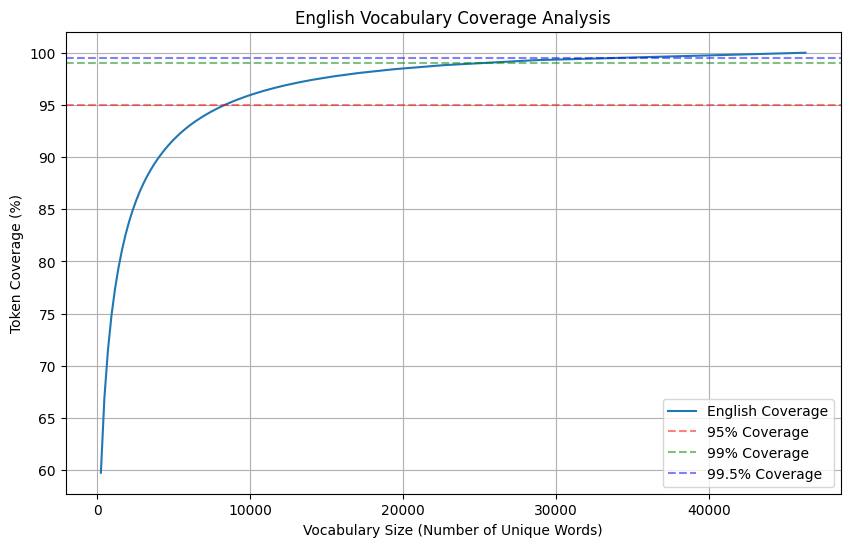

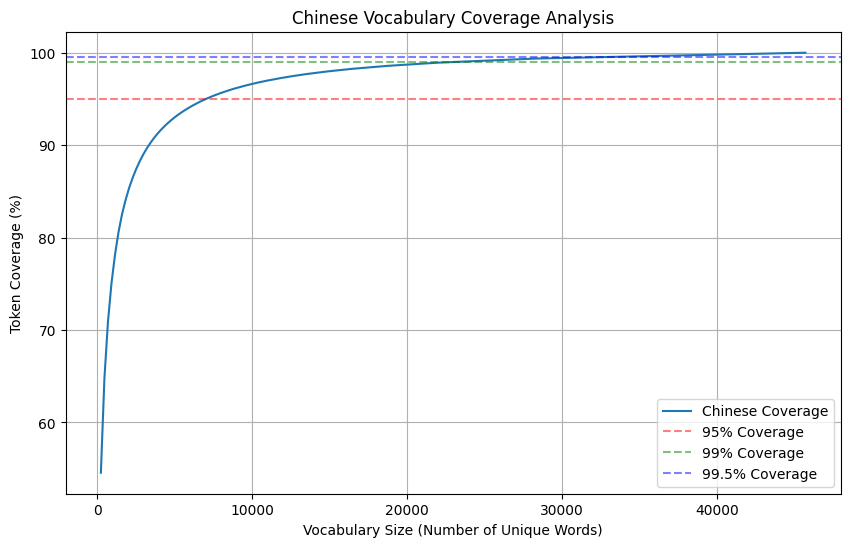

In [280]:
# 2. 覆盖率分析 (运行后会生成图片，根据控制台输出的 95%/98% 覆盖率大小来调整顶部的 MAX_VOCAB 参数)
en_counter = analyze_coverage(en_tokens, "English")
zh_counter = analyze_coverage(zh_tokens, "Chinese")


In [281]:
# 3. 构建词表
print("-" * 30)
print("构建英文词表...")
en_vocab = build_vocab(en_counter, MIN_FREQ_EN, MAX_VOCAB_EN)
print("构建中文词表...")
zh_vocab = build_vocab(zh_counter, MIN_FREQ_ZH, MAX_VOCAB_ZH)


------------------------------
构建英文词表...
最终词表大小 (含特殊Token): 40004
构建中文词表...
最终词表大小 (含特殊Token): 40004


In [282]:
zh_counter

Counter({'的': 204061,
         '，': 134566,
         '。': 101026,
         '在': 39124,
         '（': 29711,
         '）': 29710,
         '了': 29606,
         '是': 22141,
         '和': 19116,
         '—': 19048,
         '、': 18649,
         '；': 14000,
         '对': 13357,
         '这些': 13283,
         '与': 13189,
         '将': 12149,
         '：': 12120,
         '经济': 11826,
         '中': 11734,
         '会': 11457,
         '也': 11446,
         '国家': 10863,
         '美国': 10657,
         '这': 10456,
         '中国': 10191,
         '一个': 9518,
         '那些': 9419,
         '并': 9302,
         '但': 9144,
         '他们': 9083,
         '可能': 8764,
         '以及': 8558,
         '而': 8434,
         '都': 8287,
         '为': 8284,
         '问题': 8116,
         '年': 8030,
         '所': 7850,
         '被': 7739,
         '这种': 7522,
         '我们': 7347,
         '其': 7249,
         '即': 7015,
         '不': 6700,
         '来': 6441,
         '上': 6338,
         '能够': 6271,
         '更': 6156

In [283]:
# 保存词表 (JSON格式)
with open(os.path.join(OUTPUT_DIR, 'vocab_en.json'), 'w', encoding='utf-8') as f:
    json.dump(en_vocab, f, ensure_ascii=False, indent=2)
with open(os.path.join(OUTPUT_DIR, 'vocab_zh.json'), 'w', encoding='utf-8') as f:
    json.dump(zh_vocab, f, ensure_ascii=False, indent=2)


# 执行：构建英文词嵌入向量：先加载全部预训练向量 然后试图与词库匹配

In [284]:
embedding_path = GLOVE_PATH
dim = 200

# 1. 建立临时查找字典 (存储所有预训练文件中的词)
embedding_lookup = {}
with open(embedding_path, 'r', encoding='utf-8', errors='ignore') as f:
    for line in tqdm(f, desc="Reading file to memory"):
        parts = line.rstrip().split()
        if len(parts) != dim + 1:
            #print("error loading glove")
            #print(line)
            continue
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        embedding_lookup[word] = vector


Reading file to memory: 1291147it [00:39, 32928.99it/s]


## 辅助函数，处理特殊的边界情况

In [285]:
def final_fallback_match(word, embedding_lookup):
    # 1. 尝试去掉末尾标点 (如果清理漏掉了)
    clean_word = word.strip('.,…-–')
    if clean_word in embedding_lookup:
        return embedding_lookup[clean_word]
    
    # 2. 处理带有货币符号的残余 (e.g., €500 -> 查找 500)
    if any(c in word for c in '€£¥$'):
        part = re.sub(r'[^\d.]', '', word)
        if part in embedding_lookup:
            return embedding_lookup[part]
            
    return None


In [ ]:
vocab = en_vocab
dim = 200
# 2. 初始化最终矩阵
vocab_size = len(vocab)
matrix = np.random.normal(scale=0.6, size=(vocab_size, dim))
matrix[vocab[pad_TOKEN]] = np.zeros(dim)

hit_count = 0
subword_hit_count = 0
missed_words = []

# 3. 遍历我们的词表进行匹配
for word, idx in tqdm(vocab.items(), desc="Matching vocab"):
    if word in SPECIAL_TOKENS:
        continue
        
    # 场景 A: 直接命中
    if word in embedding_lookup:
        matrix[idx] = embedding_lookup[word]
        hit_count += 1
        
    # 场景 B: 带连字符的词，尝试拆分求平均
    elif '-' in word:
        # re.split('(-)', 'long-term') -> ['long', '-', 'term']
        sub_tokens = [t for t in re.split(r'(-)', word) if t]
        sub_vectors = [embedding_lookup[t] for t in sub_tokens if t in embedding_lookup]
        
        if len(sub_vectors) > 0:
            # 取子词向量的平均值
            matrix[idx] = np.mean(sub_vectors, axis=0)
            subword_hit_count += 1
        else:
            missed_words.append(word)
    else:
        vec = final_fallback_match(word, embedding_lookup)
        if vec is not None:
            matrix[idx] = vec
            hit_count += 1
        else:
            missed_words.append(word)

print(f"\n匹配完成！")
print(f"直接命中: {hit_count}")
print(f"通过连字符拆分补偿: {subword_hit_count}")
print(f"最终总命中率: {(hit_count + subword_hit_count) / (len(vocab) - 4) * 100:.2f}%")


Matching vocab: 100%|██████████| 40004/40004 [00:00<00:00, 443859.07it/s]


匹配完成！
直接命中: 33707
通过连字符拆分补偿: 5812
最终总命中率: 98.80%


In [287]:
# 找出未命中的词（排除特殊Token）
missed_report = []
for word, idx in vocab.items():
    if word in missed_words and word not in SPECIAL_TOKENS:
        # 从 counter 中获取该词在原始语料中出现的次数
        freq = en_counter.get(word, 0)
        missed_report.append((word, freq))
        
# 按词频从高到低排序
missed_report.sort(key=lambda x: x[1], reverse=True)


In [288]:
len(missed_report)

481

In [289]:
missed_report

[('gülenists', 15),
 ('lgfvs', 14),
 ('barientos', 13),
 ('spzs', 12),
 ('redd+', 12),
 ('fmlc', 12),
 ('rio+20', 10),
 ('pm2.5', 10),
 ('trumponomics', 9),
 ('microlives', 8),
 ('watsi', 8),
 ('p5+1', 7),
 ('admati', 7),
 ('asean+3', 7),
 ('aishetu', 7),
 ('ahdr', 6),
 ('jgip', 6),
 ('2°', 6),
 ('gennaioli', 6),
 ('condominialism', 5),
 ('lebacs', 5),
 ('trustless', 5),
 ('qqe', 5),
 ('cm2025', 5),
 ('ggfs', 5),
 ('gdvc', 5),
 ('wallstreetcn', 5),
 ('kanoze', 4),
 ('1.5°', 4),
 ('biopharmed', 4),
 ('geidco', 4),
 ('iffed', 4),
 ('corbynismo', 4),
 ('micromorts', 4),
 ('ndpo', 4),
 ('hensachi', 4),
 ('atito', 4),
 ('overcollateralization', 4),
 ('sentix', 4),
 ('historicide', 4),
 ('excludible', 3),
 ('inflationless', 3),
 ('lgfv', 3),
 ('g7+', 3),
 ('picuti', 3),
 ('bezzle', 3),
 ('febezzle', 3),
 ('hiftar', 3),
 ('co₂', 3),
 ('vetocracy', 3),
 ('rognlie', 3),
 ('microprudential', 3),
 ('selectocracy', 3),
 ("'too", 3),
 ('airpocalypse', 3),
 ('parapolítica', 3),
 ('tradables', 3),
 (

In [290]:
en_matrix=matrix

In [291]:
# 保存为 .npy 文件
np.save('../processed_data/en_matrix.npy', en_matrix)

# 执行： 用fasttext 做 中文 词向量嵌入：

In [ ]:
import fasttext

vocab = zh_vocab
embedding_path = FASTTEXT_PATH
dim = 300

ft_model = fasttext.load_model(FASTTEXT_PATH)

vocab_size = len(vocab)
matrix = np.zeros((vocab_size, dim)) # 初始化为全0

hit_count = 0
for word, idx in tqdm(vocab.items(), desc="Generating Vectors"):
    if word == pad_TOKEN:
        continue
        
    # get_word_vector 无论词是否在训练集中，都会返回一个向量
    # 如果词很怪异，它会通过子词（n-grams）合成向量
    matrix[idx] = ft_model.get_word_vector(word)
    hit_count += 1
        
print(f"处理完成。利用 bin 模型为所有 {hit_count} 个词生成了向量。")

Generating Vectors: 100%|██████████| 40004/40004 [00:00<00:00, 183727.88it/s]

处理完成。利用 bin 模型为所有 40003 个词生成了向量。


In [293]:
zh_matrix=matrix

In [295]:
len(zh_matrix[0])

300

In [296]:
np.save("../processed_data/zh_matrix.npy",zh_matrix)